<h1>Detection of Ampliconic gene families</h1>

In [1]:
from BCBio import GFF
from BCBio.GFF import GFFExaminer
examiner = GFFExaminer()

from Bio import SeqIO
from pprint import pprint
import copy 
import gspread
import os
import pandas as pd
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

`data_dir` folder into which reference files should be loaded prior to analysis,
expected structure

```bash
{data_dir}
├── references
│   ├── GorGor
│   │   └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_029281585.2/
│   ├── HomSap
│   │   └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_009914755.1/
│   ├── PanPan
│   │   └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_029289425.2/
│   ├── PanTro
│   │   └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_028858775.2/
│   ├── PonAbe
│   │   └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_028885655.2/
│   ├── PonPyg
│   │   └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_028885625.2/
│   └── SymSyn
│       └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_028878055.3/
│   └── MacFas
│       └── ...  # https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_037993035.2/
├── work_dir
│       └── ...
└── AdditionalFile2-SeqClasses.tsv # Download sequence classes file from additional data files
```

In [2]:
# Set the directory for the data
data_dir = "/home/emma/Amplicons/Workspaces/emma/downloaded_data"

In [3]:
work_dir = f"{data_dir}/work_dir/x_multicopy" #Creates a new working directory if it doesn't exist already
os.makedirs(work_dir, exist_ok=True) # ensures no error is raised if the directory already exists

#Define the list of dictionaries (data) containing genome information for different species
data = [
    {'species':'PanTro',
     'data': {'chr_y': "NC_072422.2",
              'chr_x': "NC_072421.2",
              'path_to_annotation_NCBI': f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/genomic.gff", #annotation file 
              'path_to_annotation_NCBI_chry': f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/genomic_chrY.gff", #Y specific annotation
              'path_to_annotation_CAT': f"{data_dir}/CAT/consensus_gene_set/GCF_028858775.2.gff3", #path to an alternate annotation format (generated by CAT pipeline)
              'ref':  f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/GCF_028858775.2_NHGRI_mPanTro3-v2.0_pri_genomic.fna", # primary reference genome file
              'rna':  f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/rna.fna", #RNA sequences 
              'prot': f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/protein.faa", #protein sequences (FASTA format)
              'cds': f"{data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/cds_from_genomic.fna", #coding DNA seq derived from genome
 }},
    {'species':'HomSap',
     'data': {'chr_y': "NC_060948.1",
              'chr_x': "NC_060947.1",
              'path_to_annotation_NCBI': f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/genomic.gff",
              'path_to_annotation_NCBI_chry': f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/genomic_chrY.gff",
              'path_to_annotation_CAT': f"{data_dir}/CAT/consensus_gene_set/hg38.gff3",
              'ref': f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna",
              'cds': f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/cds_from_genomic.fna",
              'prot': f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/protein.faa",
              }},
     {'species':'PanPan',
     'data': {'chr_y': "NC_073273.2",
              'chr_x': "NC_073272.2",
              'path_to_annotation_NCBI': f"{data_dir}/references/PanPan/ncbi_dataset/data/GCF_029289425.2/genomic.gff",
              'path_to_annotation_NCBI_chry': f"{data_dir}/references/PanPan/ncbi_dataset/data/GCF_029289425.2/genomic_chrY.gff",
              'path_to_annotation_CAT': f"{data_dir}/CAT/consensus_gene_set/GCF_029289425.2.gff3",
              'ref': f"{data_dir}/references/PanPan/ncbi_dataset/data/GCF_029289425.2/GCF_029289425.2_NHGRI_mPanPan1-v2.0_pri_genomic.fna",
              'cds': f'{data_dir}/references/PanPan/ncbi_dataset/data/GCF_029289425.2/cds_from_genomic.fna',
              'prot': f'{data_dir}/references/PanPan/ncbi_dataset/data/GCF_029289425.2/protein.faa',
              }},
      {'species':'GorGor',
     'data': {'chr_y': "NC_073248.2",
              'chr_x': "NC_073247.2",
              'path_to_annotation_NCBI': f"{data_dir}/references/GorGor/ncbi_dataset/data/GCF_029281585.2/genomic.gff",
              'path_to_annotation_NCBI_chry': f"{data_dir}/references/GorGor/ncbi_dataset/data/GCF_029281585.2/genomic_chrY.gff",
              'path_to_annotation_CAT': f"{data_dir}/CAT/consensus_gene_set/GCF_029281585.2.gff3",
              'ref': f'{data_dir}/references/GorGor/ncbi_dataset/data/GCF_029281585.2/GCF_029281585.2_NHGRI_mGorGor1-v2.0_pri_genomic.fna',
              'cds': f'{data_dir}/references/GorGor/ncbi_dataset/data/GCF_029281585.2/cds_from_genomic.fna',
              'prot': f'{data_dir}/references/GorGor/ncbi_dataset/data/GCF_029281585.2/protein.faa',
              }},
    {'species':'PonPyg',
     'data': {'chr_y': "NC_072397.2",
              'chr_x': "NC_072396.2",
              'path_to_annotation_NCBI': f"{data_dir}/references/PonPyg/ncbi_dataset/data/GCF_028885625.2/genomic.gff",
              'path_to_annotation_NCBI_chry': f"{data_dir}/references/PonPyg/ncbi_dataset/data/GCF_028885625.2/genomic_chrY.gff",
              'path_to_annotation_CAT': f"{data_dir}/CAT/consensus_gene_set/GCF_028885625.2.gff3",
              'ref': f'{data_dir}/references/PonPyg/ncbi_dataset/data/GCF_028885625.2/GCF_028885625.2_NHGRI_mPonPyg2-v2.0_pri_genomic.fna',
              'cds': f'{data_dir}/references/PonPyg/ncbi_dataset/data/GCF_028885625.2/cds_from_genomic.fna',
              'prot': f'{data_dir}/references/PonPyg/ncbi_dataset/data/GCF_028885625.2/protein.faa',
              }},
    {'species':'PonAbe',
     'data': {'chr_y': "NC_072009.2",
              'chr_x': "NC_072008.2",
              'path_to_annotation_NCBI': f"{data_dir}/references/PonAbe/ncbi_dataset/data/GCF_028885655.2/genomic.gff",
              'path_to_annotation_NCBI_chry': f"{data_dir}/references/PonAbe/ncbi_dataset/data/GCF_028885655.2/genomic_chrY.gff",
              'path_to_annotation_CAT': f"{data_dir}/CAT/consensus_gene_set/GCF_028885655.2.gff3",
              'ref': f'{data_dir}/references/PonAbe/ncbi_dataset/data/GCF_028885655.2/GCF_028885655.2_NHGRI_mPonAbe1-v2.0_pri_genomic.fna',
              'cds': f'{data_dir}/references/PonAbe/ncbi_dataset/data/GCF_028885655.2/cds_from_genomic.fna',
              'prot': f'{data_dir}/references/PonAbe/ncbi_dataset/data/GCF_028885655.2/protein.faa',
              }},    
    {'species':'SymSyn',
      'data': {'chr_y': "NC_072448.2",
               'chr_x': "NC_072447.2",
               'ref': f'{data_dir}/references/SymSyn/ncbi_dataset/data/GCF_028878055.3/GCF_028878055.3_NHGRI_mSymSyn1-v2.1_pri_genomic.fna',
               'path_to_annotation_NCBI': f"{data_dir}/references/SymSyn/ncbi_dataset/data/GCF_028878055.3/genomic.gff",
               'path_to_annotation_NCBI_chry': f"{data_dir}/references/SymSyn/ncbi_dataset/data/GCF_028878055.3/genomic_chrY.gff",
               'path_to_annotation_CAT': f"{data_dir}/CAT/consensus_gene_set/GCF_028878055.3.gff3",
               'cds': f'{data_dir}/references/SymSyn/ncbi_dataset/data/GCF_028878055.3/cds_from_genomic.fna',
               'prot': f'{data_dir}/references/SymSyn/ncbi_dataset/data/GCF_028878055.3/protein.faa',
               }},
    {'species':'MacFas',
      'data': {'chr_y': "NC_132903.1",
               'chr_x': "NC_088395.1",
               'ref': f'{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/GCF_037993035.2_T2T-MFA8v1.1_genomic.fna',
               'path_to_annotation_NCBI': f"{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/genomic.gff",
               'cds': f'{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/cds_from_genomic.fna',
               'prot': f'{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/protein.faa',
               }},
]

# Maps species identifiers to their common name
species_to_sequence_spec = {
    'PanTro': 'chimpanzee',
    'HomSap': 'human',
    'PanPan': 'bonobo',
    'GorGor': 'gorilla',
    'PonPyg': 'b-orang',
    'PonAbe': 's-orang',
    'SymSyn': 'siamang',
    'MacFas': 'macaque'
}

# Extracting species names -> list of species identifiers by iterating t
species_list = [d['species'] for d in data]

In [4]:
species_list

['PanTro',
 'HomSap',
 'PanPan',
 'GorGor',
 'PonPyg',
 'PonAbe',
 'SymSyn',
 'MacFas']

In [44]:
#subset annotation file to only include chromosome X & Y
for species in species_list:

    annotation_file =  [d for d in data if d['species'] == species][0]['data']['path_to_annotation_NCBI']
    annotation_file_x = annotation_file.replace(".gff", "_chrX.gff")
    chr = [d for d in data if d['species'] == species][0]['data']['chr_x']
    print(species, annotation_file, chr)

    ! cat $annotation_file | grep -v "#" | grep -w $chr | sort -k1,1V -k4,4n -k5,5rn -k3,3r - > $annotation_file_x

    annotation_file_y = annotation_file.replace(".gff", "_chrY.gff")
    chr = [d for d in data if d['species'] == species][0]['data']['chr_y']
    print(species, annotation_file, chr)

    ! cat $annotation_file | grep -v "#" | grep -w $chr | sort -k1,1V -k4,4n -k5,5rn -k3,3r - > $annotation_file_y

PanTro /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/PanTro/ncbi_dataset/data/GCF_028858775.2/genomic.gff NC_072421.2
PanTro /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/PanTro/ncbi_dataset/data/GCF_028858775.2/genomic.gff NC_072422.2
HomSap /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/HomSap/ncbi_dataset/data/GCF_009914755.1/genomic.gff NC_060947.1
HomSap /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/HomSap/ncbi_dataset/data/GCF_009914755.1/genomic.gff NC_060948.1
PanPan /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/PanPan/ncbi_dataset/data/GCF_029289425.2/genomic.gff NC_073272.2
PanPan /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/PanPan/ncbi_dataset/data/GCF_029289425.2/genomic.gff NC_073273.2
GorGor /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/GorGor/ncbi_dataset/data/GCF_029281585.2/genomic.gff NC_073247.2
GorGor /home/emma/Amplicons/Workspaces/emma/down

## Chromosome X

In [5]:
#runs around 20s without extracting the sequence
#runs around 1m with extracting the sequence
#only collect ID's will extract sequence from cds_from_genomic.fna
record_dict = {}

for species in species_list:


    annotation_file =  [d for d in data if d['species'] == species][0]['data']['path_to_annotation_NCBI'].replace(".gff", "_chrX.gff")
    handle = open(annotation_file)

    # pprint.pprint(examiner.parent_child_map(handle))

    # assert False

    # records = GFF.parse(handle,base_dict=seq_dict)
    records = GFF.parse(handle)
    for rec in records:
        protss = set()
        for feature in rec.features:
            if feature.type != "gene":
                continue
            if "description" in feature.qualifiers:
                description = feature.qualifiers["description"][0]

                gene_id = feature.id.replace("gene-", "")
                gene_spec_id = gene_id + "_" + species
                    
                # print(feature.qualifiers)
                for subf in feature.sub_features:

                    if subf.type == "mRNA":
                        mrna_id = subf.id.replace("rna-", "")
                        for subsubf in subf.sub_features:
                            if subsubf.type != "CDS":
                                continue
                            # cds_id = subsubf.id.replace("cds-", "")
                            prot_id = subsubf.qualifiers["protein_id"][0]
                            if prot_id in protss:
                                continue

                            protss.add(prot_id)
                            element = {}
                            element["specie"] = species
                            element["name"] = description
                            element["id"] = prot_id
                            element["mrna_id"] = mrna_id
                            element["gene_id"] = gene_id
                            element["start"] = int(subsubf.location.start)
                            element["end"] = int(subsubf.location.end)
                            element["strand"] = "+" if subsubf.location.strand == 1 else "-"  # Extracting strand (adapted from original script to later be able to look at the organization of the genes)
                            element["gene_spec_id"] = gene_spec_id
                            
                            # element["seq"] = str(subf.extract(rec.seq))
                            if gene_id in record_dict:
                                record_dict[gene_id].append(element)
                            else:
                                record_dict[gene_id] = [element]

    handle.close()

#pprint(record_dict)

In [5]:
#read sequence classes for all species
seq_class_dicts = {}
for species in species_list:

    sequence_class_file = f"{data_dir}/AdditionalFile2-SeqClasses.tsv"
    seq_class_dicts[species] = []
    with open(sequence_class_file) as f:
        for line in f:
            line = line.strip().split("\t")
            if line[0] == species_to_sequence_spec[species]:
                if line[2] == "chrX":
                    seq_class_dicts[species].append(line[2:])

In [6]:
seq_class_dicts

{'PanTro': [['chrX', '0', '591255', 'SATELLITE'],
  ['chrX', '591255', '695954', 'ANCESTRAL'],
  ['chrX', '695954', '3166326', 'PAR'],
  ['chrX', '3166326', '3424000', 'ANCESTRAL'],
  ['chrX', '3424000', '3593000', 'AMPLICONIC'],
  ['chrX', '3593000', '8612703', 'ANCESTRAL'],
  ['chrX', '8612703', '8670650', 'AMPLICONIC'],
  ['chrX', '8670650', '8987844', 'ANCESTRAL'],
  ['chrX', '8987844', '8998644', 'AMPLICONIC'],
  ['chrX', '8998644', '48626000', 'ANCESTRAL'],
  ['chrX', '48626000', '48723464', 'AMPLICONIC'],
  ['chrX', '48723464', '51703961', 'ANCESTRAL'],
  ['chrX', '51703961', '51763787', 'AMPLICONIC'],
  ['chrX', '51763787', '52083202', 'ANCESTRAL'],
  ['chrX', '52083202', '52119541', 'AMPLICONIC'],
  ['chrX', '52119541', '52219366', 'ANCESTRAL'],
  ['chrX', '52219366', '52255733', 'AMPLICONIC'],
  ['chrX', '52255733', '52498000', 'ANCESTRAL'],
  ['chrX', '52498000', '53021090', 'AMPLICONIC'],
  ['chrX', '53021090', '55492131', 'ANCESTRAL'],
  ['chrX', '55492131', '55560177', 'A

In [9]:
# Extracts the protein sequences based on the protein file of the reference genome -> extract the protein ID name and its sequence
prot_dicts = {}

for species in species_list:

    sequence_file = [d for d in data if d['species'] == species][0]['data']['prot']
    sequence_handle = open(sequence_file)
    seq_dict = SeqIO.to_dict(SeqIO.parse(sequence_handle, "fasta"))

    prot_dicts[species] = seq_dict

    sequence_handle.close()
   

In [12]:
#collect protein sequence for each gene -> match the protein ID in the record_dict dictionary (contains information about genes) to the protein ID and its sequence. It then appends the sequence
for record in record_dict:
    
    for element in record_dict[record]:
        species = element["specie"]
        id = element["id"]
        name = element["name"]
        # for prot in prot_dicts[specie]:
        #     print(prot)
        #     print(prot_dicts[specie][prot])
        #     assert False
        prot_sequences = [prot_dicts[species][x] for x in prot_dicts[species] if (id in x )]
        if len(prot_sequences) == 0:
            print("No sequence found")
            print(id)
            assert False
        seq = str(prot_sequences[0].seq)
        if len(seq) > 1:
            for prot in prot_sequences:
                if len(prot.seq) > len(seq):
                    seq = str(prot.seq)

        element["seq"] = seq


In [14]:
#reduce list of prot sequences to longest sequence per gene
gene_record_dict = {}
for record in record_dict:
    gene_spec_ids = set()
    gene_spec_elements = []
    
    for element in record_dict[record]:
        # gene_id = element["gene_id"]
        gene_spec_id = element["gene_spec_id"]
        
        if gene_spec_id not in gene_spec_ids:
            gene_spec_elements.append(element)
        else:
            if len(element["seq"]) > len([x for x in gene_spec_elements if x["gene_spec_id"] == gene_spec_id][0]["seq"]):
                for el in gene_spec_elements:
                    if el["gene_spec_id"] == gene_spec_id:
                        el["seq"] = element["seq"]
                        break

        gene_spec_ids.add(element["gene_spec_id"])
    
    gene_record_dict[record] = gene_spec_elements

#pprint(gene_record_dict)

In [21]:
#print one protein file per specie
cmd = f"mkdir -p {work_dir}/protein_extracted_longest"
subprocess.run(cmd, shell=True)
for species in species_list:
    file = f"{work_dir}/protein_extracted_longest/{species}.faa"


    species_records = {}
    for gene in gene_record_dict:
        species_records[gene] = []
        for element in gene_record_dict[gene]:
            if element["specie"] == species:
                species_records[gene].append(element)


    with open(file, "w") as outfile:
        for entry in species_records:
            element = species_records[entry]
            if len(element) > 1:
                print(species)
                assert False
            if len(element) == 0:
                continue
            element = element[0]
            outfile.write(f">{element['id']} gene:{element['gene_id']} mrna:{element['mrna_id']} {element['specie']} {element['name']}\n")
            outfile.write(f"{element['seq']}\n")

In [22]:
#Create a BLAST database from the protein files generate above. 
cmd = f"mkdir -p {work_dir}/protein_extracted_longest/blastdb" #create the directory
subprocess.run(cmd, shell=True, check=True) #execute the command

#concatanate all fasta files into one
cmd = f"cat {work_dir}/protein_extracted_longest/*.faa \
    > {work_dir}/protein_extracted_longest/blastdb/all_proteins.faa" #matches all the .faa files (protein files for all species in the protein_extracted_longest foder
# run command 
subprocess.run(cmd, shell=True, check=True) #execute the command. A concanated FASTA file is created -> contains all protein sequences from the .faa files created earlier, with their respective headers. 

CompletedProcess(args='cat /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/*.faa     > /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/blastdb/all_proteins.faa', returncode=0)

In [23]:
#use the makeblastbd command to create a BLAST database from the concatenated FASTA file of protein sequences. 
cmd = f"makeblastdb -in {work_dir}/protein_extracted_longest/blastdb/all_proteins.faa \
     -dbtype prot\
     -out {work_dir}/protein_extracted_longest/blastdb/all_proteins"

subprocess.run(cmd, shell=True, check=True)



Building a new DB, current time: 05/26/2025 15:47:44
New DB name:   /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/blastdb/all_proteins
New DB title:  /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/blastdb/all_proteins.faa
Sequence type: Protein
Deleted existing Protein BLAST database named /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/blastdb/all_proteins
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 7620 sequences in 0.14383 seconds.




CompletedProcess(args='makeblastdb -in /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/blastdb/all_proteins.faa      -dbtype prot     -out /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/blastdb/all_proteins', returncode=0)

In [25]:
#Run a BLAST search for each species' protein sequences against the BLAST database created. 
# blast all against DB
for s in species_list:
    cmd = f"blastp -query {work_dir}/protein_extracted_longest/{s}.faa \
    -db {work_dir}/protein_extracted_longest/blastdb/all_proteins \
    -out {work_dir}/protein_extracted_longest/{s}.blastp.tsv \
    -outfmt \"6 qseqid sseqid pident mismatch gapopen gaps qcovs qcovshsp evalue\" "
    subprocess.run(cmd, shell=True, check=True)

In [15]:
#collect edges for each protein
edges = {}
identity = 50
coverage = 35
score = 0.001 

for s in species_list:
    file = f"{work_dir}/protein_extracted_longest/{s}.blastp.tsv"
    with open(file, "r") as infile:
        for line in infile:
            line = line.strip().split("\t")
            if float(line[2]) >= identity and int(line[6]) >= coverage and float(line[7]) < score:
                if line[0] in edges:
                    edges[line[0]].append(line[1])
                else:
                    edges[line[0]] = [line[1]]

In [17]:
#only keep two way edges
edges_2way = []
vertices = set()
for node_A in edges:
    for node_B in edges[node_A]:
        if node_B in edges and node_A in edges[node_B]:
            tuple = (node_A, node_B)
            tuple = sorted(tuple)

            if tuple in edges_2way:
                continue

            edges_2way.append(tuple)
            vertices.add(node_A)
            vertices.add(node_B)     

In [19]:
#create clusters with transitive clusering
clusters = []
for edge in edges_2way:
    found = False
    for cluster in clusters:
        if edge[0] in cluster or edge[1] in cluster:
            cluster.add(edge[0])
            cluster.add(edge[1])
            found = True
            break
    if not found:
        clusters.append(set(edge))


#merge clusters with common elements
merged_clusters = []
for cluster in clusters:
    found = False
    for merged_cluster in merged_clusters:
        if len(cluster.intersection(merged_cluster)) > 0:
            merged_cluster.update(cluster)
            found = True
            break
    if not found:
        merged_clusters.append(cluster)

In [21]:
# Link every protein to a their original species
prot_to_species = {}

for cluster in merged_clusters:

    for prot in cluster:
        # print(prot)
        species = ""
        for gene in gene_record_dict:
            for element in gene_record_dict[gene]:
                if element["id"] == prot:
                    species = element["specie"]
                    prot_to_species[prot] = species
                        

In [23]:
#read blast results into pandas dataframe
# columns :species, gene_A, gene_B, identity, coverage, evalue

data_frames = {}
for species in species_list:
    blast_results = pd.DataFrame(columns=["gene_A", "gene_B", "identity", "coverage", "evalue"]) 
    blast_results_list = []
    file = f"{work_dir}/protein_extracted_longest/{species}.blastp.tsv"
    with open(file, "r") as infile:
        for line in infile:
            line = line.strip().split("\t")
            # if float(line[2]) >= identity and int(line[6]) >= coverage and float(line[7]) < score:
            blast_results_list.append({"species": species, "gene_A": line[0], "gene_B": line[1], "identity": line[2], "coverage": line[6], "evalue": line[7]})

    blast_results = pd.DataFrame(blast_results_list)
    data_frames[species] = blast_results

In [25]:
palindrome_locations_file_path = "./PalindromeLocations.tsv" #this file is distributed along the code
species_trans = {
    "HomSap_x": "chm13"    ,
    "HomSap_y": "hg002"    ,
    "GorGor": "mGorGor1" ,
    "PanTro": "mPanTro3" ,
    "PanPan": "mPanPan1" ,
    "PonAbe": "mPonAbe1" ,
    "PonPyg": "mPonPyg2" ,
    "SymSyn": "mSymSyn1" 
}
palindrome_locations_file = open(palindrome_locations_file_path, "r")
palindrome_locations = palindrome_locations_file.readlines()
palindrome_locations_file.close()
chr = "x"

palindrome_lines_per_species = {}

for species in species_list:
    # Build the list of translation keys we actually have (HomSap is divided into X and Y so this should be taken into account):
    if species == "HomSap":
        raw_keys = [f"{species}_x", f"{species}_y"]
    else:
        raw_keys = [species]
    # Only keep keys that exist in species_trans. Check if species exists in species_trans -> BECAUSE MacFas does not have palindrome information so this should be empty

    keys = [k for k in raw_keys if k in species_trans]

    # If none of those keys are in species_trans, just give an empty list and skip
    if not keys:
        palindrome_lines_per_species[species] = []
        continue
        
    palindrome_lines = []
        
    for row in palindrome_locations:
        row = row.strip().split("\t")
        if len(row) < 4:
            continue
        if row[1] != '' and row[1] != 'start':
                    
            if species == "HomSap":
                sp = f"{species}_{chr}"
                species_chr = f"{species_trans[sp]}.chr{chr.upper()}"
            else:
                species_chr = f"{species_trans[species]}.chr{chr.upper()}"

            if row[0] == species_chr:
                palindrome_lines.append([x.replace(',','') for x in row])
    palindrome_lines_per_species[species] = palindrome_lines

In [7]:
#palindrome_lines_per_species

In [28]:
# Create a directory as a shell command
cmd = f"mkdir -p {work_dir}/protein_extracted_longest/clusters_merged"
subprocess.run(cmd, shell=True, check=True)

file = open(f"{work_dir}/protein_extracted_longest/clusters_merged/clusters.tsv", "w")
file_identities = open(f"{work_dir}/protein_extracted_longest/clusters_merged/clusters_identities.tsv", "w")
file_classes = open(f"{work_dir}/protein_extracted_longest/clusters_merged/clusters_classes.tsv", "w")
 
header = "id\tgene_symbol\tDescription(s)"
for species in species_list:
    header += f"\t{species}"

print(header, file=file)
print(header, file=file_identities)
print(header, file=file_classes)

counter = 0
prot_to_cluster = {}
list_of_all_identities = []

for cluster in merged_clusters:

    cluster_copy = copy.deepcopy(cluster)
    counter += 1
    species_count = {}
    gene_names = set()
    gene_symbol = ""
    report = False
    gene_identity_counter_per_species = {}

    #class counter intialization -> so initialize counters for sequences classes (PAR, ampliconic, ancestral, palindrome), per species
    classes_per_species = {}
    for species in species_list:
        classes_per_species[species] = {
                "par_counter" : 0,
                "ampl_counter" : 0,
                "ancestral_counter" : 0,
                "palindrome_counter" : 0
        }
    
    # create cluster FASTA file 
    # write sequences for each cluster into a seperate FASTA file for further analysis
    # then match proteins to their repsective genes using gene_record_dict and extract relevant information (species, description, sequence) 
    # HERE THERE SHOULD BE START AND END coordinates??
    cluster_fasta_file = f"{work_dir}/protein_extracted_longest/clusters_merged/cluster_{counter}.faa"
    with open(cluster_fasta_file, "w") as cluster_outfile:
        for prot in cluster:
            # print(prot)
            species = ""
            desc = ""
            for gene in gene_record_dict:
                for element in gene_record_dict[gene]:
                    if element["id"] == prot:
                        #print("Element dictionary:", element)
                        gene_names.add(element["name"])
                        species = element["specie"]
                        # print(element)
                        desc = element["name"]
                        report_gene = gene

                        prot_to_cluster[prot] = counter
                        
                        if species in species_count:
                            report = True
                            # species = element
                            species_count[species] += 1
                        else:
                            species_count[species] = 1
                        sequence = element["seq"]

                        el_start =  element["start"]
                        el_end =  element["end"]
                        
                        #Determine which class (PAR, ampliconic, ancestral) the sequence belongs to, based on genomic coordinates. SO HERE IT USES COORDINATES?!
                        for seq_class in seq_class_dicts[species]:
                            class_name = seq_class[3]
                            if el_start >= int(seq_class[1]) and el_end <= int(seq_class[2]):

                                if seq_class[3] == "PAR":
                                    classes_per_species[species]["par_counter"] += 1
                                elif seq_class[3] == "AMPLICONIC":
                                    classes_per_species[species]["ampl_counter"] += 1
                                elif seq_class[3] == "ANCESTRAL" :
                                    classes_per_species[species]["ancestral_counter"] += 1
                                break
                            else:
                                #TODO if more than 50% of the sequence is in the class, count it as in the class
                                
                                if el_start < int(seq_class[1]) and el_end > int(seq_class[1]):
                                    if int(seq_class[1]) - el_start > 0.5 * len(sequence):
                                        if seq_class[3] == "PAR":
                                            classes_per_species[species]["par_counter"] += 1
                                        elif seq_class[3] == "AMPLICONIC":
                                            classes_per_species[species]["ampl_counter"] += 1
                                        elif seq_class[3] == "ANCESTRAL":
                                            classes_per_species[species]["ancestral_counter"] += 1
                                        break
                                if el_start < int(seq_class[2]) and el_end > int(seq_class[2]):
                                    if el_end - int(seq_class[2]) > 0.5 * len(sequence):
                                        if seq_class[3] == "PAR":
                                            classes_per_species[species]["par_counter"] += 1
                                        elif seq_class[3] == "AMPLICONIC":
                                            classes_per_species[species]["ampl_counter"] += 1
                                        elif seq_class[3] == "ANCESTRAL":
                                            classes_per_species[species]["ancestral_counter"] += 1
                                        break

                        # check if the sequence is within palindrome regions and count accordingly 
                        for palindrome in palindrome_lines_per_species[species]:
                            if el_start >= int(palindrome[1]) and el_end <= int(palindrome[2]):
                                if counter == 21:
                                    print(palindrome)
                                classes_per_species[species]["palindrome_counter"] += 1
                                break
                            else:
                                if el_start < int(palindrome[1]) and el_end > int(palindrome[2]):
                                    
                                    print(f"start: {el_start} end: {el_end} palindrome: {palindrome[0]} start: {palindrome[1]} end: {palindrome[2]}")
                                    assert False
                                if el_start < int(palindrome[1]) and el_end > int(palindrome[2]):
                                    print(f"start: {el_start} end: {el_end} palindrome: {palindrome[0]} start: {palindrome[1]} end: {palindrome[2]}")
                                    assert False

                        if element["specie"] == "HomSap":
                            if gene.startswith("LOC"):
                                continue
                            gene_symbol = gene
                        break
            
            print(f">{prot}_gene:{report_gene}_species:{species} description:{desc}\n{sequence}", file=cluster_outfile)   
            for prot_B in cluster_copy:
                if prot == prot_B:
                    continue
                species = prot_to_species[prot]
                if species != prot_to_species[prot_B]:
                    continue
                # blast results initiated in later cells, TODO: move to top
                blast_results = data_frames[species]
                blast_result = blast_results[(blast_results["gene_A"] == prot) & (blast_results["gene_B"] == prot_B)]
                if blast_result.empty:
                    continue

                identity1 = blast_result.iloc[0]["identity"]

                blast_result = blast_results[(blast_results["gene_A"] == prot_B) & (blast_results["gene_B"] == prot)]
                if blast_result.empty:
                    continue
                identity2 = blast_result.iloc[0]["identity"]

                if identity2 < identity1:
                    identity1 = identity2
                if species not in gene_identity_counter_per_species:
                    gene_identity_counter_per_species[species] = f"{identity1}"
                else:
                    gene_identity_counter_per_species[species] += f";{identity1}"
                list_of_all_identities.append(float(identity1))
            cluster_copy.remove(prot)

# once processing is complete, write the collected information (clusters, identities, classes) into respective file           
    if report:
        
        if gene_symbol == "":
            gene_symbol = list(gene_names)[0]
        line = f"{counter}\t{gene_symbol}\t{';'.join(gene_names)}"
        for species in species_list:
            if species not in species_count:
                species_count[species] = 0
            line += f"\t{species_count[species]}"

        print(line, file=file)

        identity_line = f"{counter}\t{gene_symbol}\t{';'.join(gene_names)}"
        for species in species_list:
            if species not in gene_identity_counter_per_species:
                gene_identity_counter_per_species[species] = 0
            identity_line += f"\t{gene_identity_counter_per_species[species]}"
        print(identity_line, file=file_identities)

        class_line = f"{counter}\t{gene_symbol}\t{';'.join(gene_names)}"
        
        per_line_class_counter = {
            "par_counter" : 0 ,
            "ampl_counter" : 0,
            "ancestral_counter" : 0,
            "palindrome_counter" : 0
        }
        for species in species_list:
            par_counter = classes_per_species[species]["par_counter"]
            per_line_class_counter["par_counter"] += par_counter
            ampl_counter = classes_per_species[species]["ampl_counter"]
            per_line_class_counter["ampl_counter"] += ampl_counter
            ancestral_counter = classes_per_species[species]["ancestral_counter"]
            per_line_class_counter["ancestral_counter"] += ancestral_counter
            palindrome_counter = classes_per_species[species]["palindrome_counter"]
            per_line_class_counter["palindrome_counter"] += palindrome_counter
            class_line += f"\t{ampl_counter} ({palindrome_counter}) + {ancestral_counter} + {par_counter}"


        class_line += f"\t{per_line_class_counter['ampl_counter']} ({per_line_class_counter['palindrome_counter']}) + {per_line_class_counter['ancestral_counter']} + {per_line_class_counter['par_counter']}"
        print(class_line, file=file_classes)

#close files
file.close()
file_identities.close()
file_classes.close()

In [29]:
## Extract the genes coordinates and which classification they belong to. 
output_dir = f"{work_dir}/protein_extracted_longest/clusters_merged"
os.makedirs(output_dir, exist_ok=True)
gene_details_file_path = os.path.join(output_dir, "gene_details.tsv")

with open(gene_details_file_path, "w") as gene_details_file:
    # Write header to the file
    print("Species\tGene\tGene_symbol\tStart\tEnd\tStrand\tClass", file=gene_details_file)

    # Iterate over each species and their corresponding genes
    for species in species_list:
        for gene in gene_record_dict:
            for element in gene_record_dict[gene]:
                if element["specie"] == species:
                    gene_name = element["name"]
                    gene_symbol = gene
                    start = element["start"]
                    end = element["end"]
                    sequence_class = "Unknown"
                    strand = element["strand"]

                    # Determine the sequence class
                    for seq_class in seq_class_dicts[species]:
                        if start >= int(seq_class[1]) and end <= int(seq_class[2]):
                            sequence_class = seq_class[3]
                            break

                    # Print gene details to the file
                    print(f"{species}\t{gene_name}\t{gene_symbol}\t{start}\t{end}\t{strand}\t{sequence_class}", file=gene_details_file)

print(f"Gene details have been saved to {gene_details_file_path}")

Gene details have been saved to /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/x_multicopy/protein_extracted_longest/clusters_merged/gene_details.tsv


In [30]:
# Extract only the ampliconic gene families 
# Defined as sequence identity for at least two copies have ≥97% sequence identity within at least one species.

# Load the Cluster identities TSV file
df = pd.read_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/clusters_identities.tsv", sep='\t')

# Check if at least 2 copies have >= 97% identity
def is_ampliconic(sequence_identities):
    # Split the string by semicolons and convert to floats
    identities = [float(identity) for identity in sequence_identities.split(';') if identity]
    
    # Check if at least one species has 2 or more identities >= 97%
    return sum([identity >= 97.0 for identity in identities]) >= 1

# Filter the rows based on the condition for PanTro, HomSap, and PanPan
filtered_rows = []

for idx, row in df.iterrows():
    if is_ampliconic(row['PanTro']) or is_ampliconic(row['HomSap']) or is_ampliconic(row['PanPan']) or is_ampliconic(row['GorGor']) or is_ampliconic(row['PonPyg']) or is_ampliconic(row['PonAbe']) or is_ampliconic(row['SymSyn']):
        filtered_rows.append(row)

# Create a new dataframe with only the ampliconic families
ampliconic_df = pd.DataFrame(filtered_rows)

# Save the filtered dataframe to a new TSV file
ampliconic_df.to_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/ampliconic_families.tsv", sep='\t', index=False)

In [31]:
# append the gene family to the genes of the gene_details.tsv file 
# Load the gene_details and clusters files
gene_details_file = f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details.tsv"
clusters_file = f"{work_dir}/protein_extracted_longest/clusters_merged/ampliconic_families.tsv"

gene_details_df = pd.read_csv(gene_details_file, sep='\t')
clusters_df = pd.read_csv(clusters_file, sep='\t')

gene_details_df["gene_family_symbol"] = ""

# Iterate through each row in gene_details_df
for index, row in gene_details_df.iterrows():
    gene_name = row["Gene"]
    
    # Search for the gene_name in the "Description(s)" column of clusters_df
    matching_row = clusters_df[clusters_df["Description(s)"].str.contains(gene_name, na=False, regex=False)]
    
    if not matching_row.empty:
        # Get the gene_symbol from the matching row
        gene_symbol = matching_row.iloc[0]["gene_symbol"]
        # Append the gene_symbol to the "gene_family_symbol" column in gene_details_df
        gene_details_df.at[index, "gene_family_symbol"] = gene_symbol

# Save the updated DataFrame back to a new file
gene_details_df.to_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details_updated.tsv", sep='\t', index=False)

print("Updated gene_details.tsv with gene_family_symbol column.")

Updated gene_details.tsv with gene_family_symbol column.


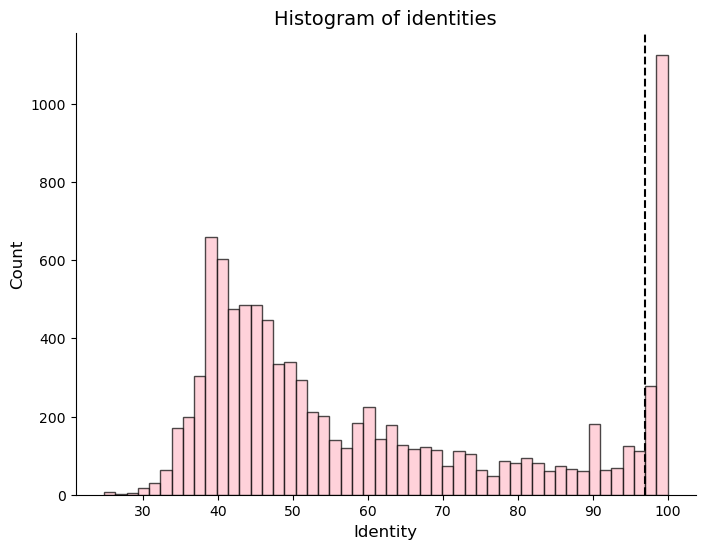

In [32]:
#bin list of identities by values 50 to 55, 55 to 60, 60 to 65, 65 to 70, 70 to 75, 75 to 80, 80 to 85, 85 to 90, 90 to 95, 95 to 100
plt.figure(figsize=(8, 6))

plt.hist(list_of_all_identities, bins = 50, color = 'Pink', edgecolor='black', alpha = 0.7)
# plt.yscale('log')
plt.xlabel('Identity', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Histogram of identities', fontsize = 14)

#remove frame and white space around plot
sns.despine()
# Add a black dashed vertical line at x = 97
plt.axvline(x=97, color='black', linestyle='--')

plt.savefig(f"{work_dir}/protein_extracted_longest/clusters_merged/identity_histogram.")
# plt.yscale('log')
# plt.savefig(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/identity_histogram_log.png")

In [33]:
# Apply whether a gene lays within a palindrome
gene_details_df = pd.read_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details_updated.tsv", sep='\t')

## Check if a gene is within any palindrome
def check_palindrome(specie, gene_start, gene_end):
    # Get the list of palindromes for the given species
    if specie in palindrome_lines_per_species:
        palindromes = palindrome_lines_per_species[specie]
        
        for palindrome in palindromes:
            _, pal_start, pal_end, _, pal_name = palindrome
            
            # Convert coordinates to integers
            pal_start = int(pal_start)
            pal_end = int(pal_end)
            
            # Check if gene coordinates fall within the palindrome range
            if gene_start >= pal_start and gene_end <= pal_end:
                return 'yes', pal_name
    
    return 'no', None
    
# New columns to be added
gene_details_df['in_palindrome'] = 'no'
gene_details_df['palindrome_name'] = None

# Iterate over each row in the dataframe
for idx, row in gene_details_df.iterrows():
    species = row['Species']  # Assuming column named 'specie'
    gene_start = row['Start']  # Assuming column named 'start'
    gene_end = row['End']  # Assuming column named 'end'
    
    in_palindrome, palindrome_name = check_palindrome(species, gene_start, gene_end)
    
    # Update the dataframe with the results
    gene_details_df.at[idx, 'in_palindrome'] = in_palindrome
    gene_details_df.at[idx, 'palindrome_name'] = palindrome_name

# Save the updated dataframe to a new file
gene_details_df.to_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes.tsv", sep='\t', index=False)

gene_details_df

,Species,Gene,Gene_symbol,Start,End,Strand,Class,gene_family_symbol,in_palindrome,palindrome_name
0,PanTro,MAM and LDL-receptor class A domain-containing...,LOC104004304,645722,645746,-,ANCESTRAL,NaN,no,None
1,PanTro,PI-PLC X domain-containing protein 1,LOC104004678,733989,734116,+,PAR,NaN,no,None
2,PanTro,putative GTP-binding protein 6,LOC107971128,754146,754270,-,PAR,NaN,no,None
3,PanTro,serine/threonine-protein phosphatase 2A regula...,LOC112207609,781156,781307,-,PAR,NaN,no,None
4,PanTro,short stature homeobox protein,LOC107971217,1118844,1119121,+,PAR,NaN,no,None
...,...,...,...,...,...,...,...,...,...,...
7615,MacFas,cancer/testis antigen 1-like,LOC102119988,160768729,160768977,+,Unknown,LAGE3,no,None
7616,MacFas,histone H2A-Bbd type 2/3-like,LOC123571317,161473448,161473796,+,Unknown,H2AB3,no,None
7617,MacFas,40-kDa huntingtin-associated protein,LOC135969152,161474876,161475995,+,Unknown,F8A2,no,None
7618,MacFas,40-kDa huntingtin-associated protein,LOC123571316,161508487,161509957,-,Unknown,F8A2,no,None


In [36]:
# UPDATE THE GENE COORDINATES! they are not the full gene length now
gene_details_file = f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes.tsv"
df = pd.read_csv(gene_details_file, sep="\t")
df

species_to_gff = {
    d['species']: d['data']['path_to_annotation_NCBI'].replace(".gff", "_chrX.gff")
    for d in data
}

def parse_gene_coords(gff_path):
    coords = {}
    with open(gff_path) as g:
        for line in g:
            if line.startswith('#'): continue
            chrom,src,feat,start,end,_,_,_,attr = line.split('\t',8)
            if feat != 'gene': continue
            # pull out gene_symbol (or fallback to gene=)
            md = dict(item.split('=',1) for item in attr.split(';') if '=' in item)
            sym = md.get('gene_symbol') or md.get('gene')
            if sym:
                coords[sym] = (int(start), int(end))
    return coords

gff_cache = {
    sp: parse_gene_coords(path)
    for sp, path in species_to_gff.items()
}

# replace Start/End 
new_starts, new_ends = [], []
for _, row in df.iterrows():
    sp, sym = row['Species'], row['Gene_symbol']
    start,end = gff_cache[sp].get(sym, (row['Start'], row['End']))
    new_starts.append(start)
    new_ends.append(end)

df['Start'] = new_starts
df['End']   = new_ends
df

# save the table 
df.to_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes_coordinates.tsv", sep="\t", index=False)

In [37]:
# remove all rows that have NaN in gene_family_symbol -> all the ones that are not part of a ampliconic gene family
df = df.dropna(subset=["gene_family_symbol"])
df.to_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes_coordinates.tsv", sep="\t", index=False)
df

,Species,Gene,Gene_symbol,Start,End,Strand,Class,gene_family_symbol,in_palindrome,palindrome_name
6,PanTro,colony stimulating factor 2 receptor subunit a...,LOC746936,1771418,1838874,+,PAR,CSF2RA,no,NaN
23,PanTro,sperm protein associated with the nucleus on t...,LOC129388397,3486949,3488083,+,AMPLICONIC,SPANXA1,no,NaN
24,PanTro,SPANX A/D member 3,LOC493983,3566190,3567169,+,AMPLICONIC,SPANXA1,no,NaN
28,PanTro,protein kinase X-linked,PRKX,4149880,4259574,-,ANCESTRAL,TBL1X,no,NaN
29,PanTro,atherin-like,LOC740134,4370640,4405131,-,ANCESTRAL,TBL1X,no,NaN
...,...,...,...,...,...,...,...,...,...,...
7615,MacFas,cancer/testis antigen 1-like,LOC102119988,160766910,160770217,+,Unknown,LAGE3,no,NaN
7616,MacFas,histone H2A-Bbd type 2/3-like,LOC123571317,161473449,161473969,+,Unknown,H2AB3,no,NaN
7617,MacFas,40-kDa huntingtin-associated protein,LOC135969152,161474855,161476570,+,Unknown,F8A2,no,NaN
7618,MacFas,40-kDa huntingtin-associated protein,LOC123571316,161507913,161509975,-,Unknown,F8A2,no,NaN


## Y-Chromosome

In [5]:
#runs around 20s without extracting the sequence
#runs around 1m with extracting the sequence
#only collect ID's will extract sequence from cds_from_genomic.fna
record_dict = {}

for species in species_list:


    annotation_file =  [d for d in data if d['species'] == species][0]['data']['path_to_annotation_NCBI'].replace(".gff", "_chrY.gff")
    handle = open(annotation_file)

    # pprint.pprint(examiner.parent_child_map(handle))

    # assert False

    # records = GFF.parse(handle,base_dict=seq_dict)
    records = GFF.parse(handle)
    for rec in records:
        protss = set()
        for feature in rec.features:
            if feature.type != "gene":
                continue
            if "description" in feature.qualifiers:
                description = feature.qualifiers["description"][0]

                gene_id = feature.id.replace("gene-", "")
                gene_spec_id = gene_id + "_" + species
                    
                # print(feature.qualifiers)
                for subf in feature.sub_features:

                    if subf.type == "mRNA":
                        mrna_id = subf.id.replace("rna-", "")
                        for subsubf in subf.sub_features:
                            if subsubf.type != "CDS":
                                continue
                            # cds_id = subsubf.id.replace("cds-", "")
                            prot_id = subsubf.qualifiers["protein_id"][0]
                            if prot_id in protss:
                                continue

                            protss.add(prot_id)
                            element = {}
                            element["specie"] = species
                            element["name"] = description
                            element["id"] = prot_id
                            element["mrna_id"] = mrna_id
                            element["gene_id"] = gene_id
                            element["start"] = int(subsubf.location.start)
                            element["end"] = int(subsubf.location.end)
                            element["strand"] = "+" if subsubf.location.strand == 1 else "-"  # Extracting strand (adapted from original script to later be able to look at the organization of the genes)
                            element["gene_spec_id"] = gene_spec_id

                            # element["seq"] = str(subf.extract(rec.seq))
                            if gene_id in record_dict:
                                record_dict[gene_id].append(element)
                            else:
                                record_dict[gene_id] = [element]

    handle.close()

#pprint(record_dict)

In [6]:
#read sequence classes for all species
seq_class_dicts = {}
for species in species_list:

    sequence_class_file = f"{data_dir}/AdditionalFile2-SeqClasses.tsv"
    seq_class_dicts[species] = []
    with open(sequence_class_file) as f:
        for line in f:
            line = line.strip().split("\t")
            if line[0] == species_to_sequence_spec[species]:
                if line[2] == "chrY":
                    seq_class_dicts[species].append(line[2:])

In [8]:
#pprint(seq_class_dicts)

In [8]:
# read the cds_from_genomic.fna file
prot_dicts = {}

for species in species_list:

    sequence_file = [d for d in data if d['species'] == species][0]['data']['prot']
    sequence_handle = open(sequence_file)
    seq_dict = SeqIO.to_dict(SeqIO.parse(sequence_handle, "fasta"))

    prot_dicts[species] = seq_dict

    sequence_handle.close()

In [9]:
for record in record_dict:
    
    for element in record_dict[record]:
        species = element["specie"]
        id = element["id"]
        name = element["name"]
        prot_sequences = [prot_dicts[species][x] for x in prot_dicts[species] if (id in x )]
        if len(prot_sequences) == 0:
            print("No sequence found")
            print(id)
            assert False
        seq = str(prot_sequences[0].seq)
        if len(seq) > 1:
            for prot in prot_sequences:
                if len(prot.seq) > len(seq):
                    seq = str(prot.seq)

        element["seq"] = seq

In [11]:
#reduce list of prot sequences to longest sequence per gene
gene_record_dict = {}
for record in record_dict:
    gene_spec_ids = set()
    gene_spec_elements = []
    
    for element in record_dict[record]:
        # gene_id = element["gene_id"]
        gene_spec_id = element["gene_spec_id"]
        
        if gene_spec_id not in gene_spec_ids:
            gene_spec_elements.append(element)
        else:
            if len(element["seq"]) > len([x for x in gene_spec_elements if x["gene_spec_id"] == gene_spec_id][0]["seq"]):
                for el in gene_spec_elements:
                    if el["gene_spec_id"] == gene_spec_id:
                        el["seq"] = element["seq"]
                        break

        gene_spec_ids.add(element["gene_spec_id"])
    
    gene_record_dict[record] = gene_spec_elements

#pprint(gene_record_dict)

In [12]:
#print one protein file per specie
for species in species_list:
    file = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/{species}.faa"


    species_records = {}
    for gene in gene_record_dict:
        species_records[gene] = []
        for element in gene_record_dict[gene]:
            if element["specie"] == species:
                species_records[gene].append(element)


    with open(file, "w") as outfile:
        for entry in species_records:
            element = species_records[entry]
            if len(element) > 1:
                print(species)
                assert False
            if len(element) == 0:
                continue
            element = element[0]
            outfile.write(f">{element['id']} gene:{element['gene_id']} mrna:{element['mrna_id']} {element['specie']} {element['name']}\n")
            outfile.write(f"{element['seq']}\n")

In [13]:
#make blast db
cmd = f"mkdir -p {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/blastdb"
subprocess.run(cmd, shell=True, check=True)
#concat all fasta files
cmd = f"cat {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/*.faa \
    > {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/blastdb/all_proteins.faa"
# run command
subprocess.run(cmd, shell=True, check=True)

CompletedProcess(args='cat /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/*.faa     > /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/blastdb/all_proteins.faa', returncode=0)

In [14]:
#make blast db
cmd = f"makeblastdb -in {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/blastdb/all_proteins.faa \
     -dbtype prot\
     -out {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/blastdb/all_proteins"

subprocess.run(cmd, shell=True, check=True)



Building a new DB, current time: 02/02/2026 09:35:51
New DB name:   /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/blastdb/all_proteins
New DB title:  /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/blastdb/all_proteins.faa
Sequence type: Protein
Deleted existing Protein BLAST database named /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/blastdb/all_proteins
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 761 sequences in 0.102918 seconds.




CompletedProcess(args='makeblastdb -in /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/blastdb/all_proteins.faa      -dbtype prot     -out /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/blastdb/all_proteins', returncode=0)

In [15]:
# blast all against DB
for s in species_list:
    cmd = f"blastp -query {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/{s}.faa \
    -db {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/blastdb/all_proteins \
    -out {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/{s}.blastp.tsv \
    -outfmt \"6 qseqid sseqid pident mismatch gapopen gaps qcovs qcovshsp evalue\" "
    subprocess.run(cmd, shell=True, check=True)

In [16]:
#collect edges for each protein
edges = {}
identity = 50
coverage = 35
score = 0.001 

for s in species_list:
    file = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/{s}.blastp.tsv"
    with open(file, "r") as infile:
        for line in infile:
            line = line.strip().split("\t")
            if float(line[2]) >= identity and int(line[6]) >= coverage and float(line[7]) < score:
                if line[0] in edges:
                    edges[line[0]].append(line[1])
                else:
                    edges[line[0]] = [line[1]]


In [17]:
#only keep two way edges
edges_2way = []
vertices = set()
for node_A in edges:
    for node_B in edges[node_A]:
        if node_B in edges and node_A in edges[node_B]:
            tuple = (node_A, node_B)
            tuple = sorted(tuple)

            if tuple in edges_2way:
                continue

            edges_2way.append(tuple)
            vertices.add(node_A)
            vertices.add(node_B)          

In [20]:
#create clusters with transitive clusering
clusters = []
for edge in edges_2way:
    found = False
    for cluster in clusters:
        if edge[0] in cluster or edge[1] in cluster:
            cluster.add(edge[0])
            cluster.add(edge[1])
            found = True
            break
    if not found:
        clusters.append(set(edge))


#merge clusters with common elements
merged_clusters = []
for cluster in clusters:
    found = False
    for merged_cluster in merged_clusters:
        if len(cluster.intersection(merged_cluster)) > 0:
            merged_cluster.update(cluster)
            found = True
            break
    if not found:
        merged_clusters.append(cluster)

#merged_clusters

In [21]:
prot_to_species = {}

for cluster in merged_clusters:

    for prot in cluster:
        # print(prot)
        species = ""
        for gene in gene_record_dict:
            for element in gene_record_dict[gene]:
                if element["id"] == prot:
                    species = element["specie"]
                    prot_to_species[prot] = species
                        

In [22]:
#read blast results into pandas dataframe
# columns :species, gene_A, gene_B, identity, coverage, evalue



data_frames = {}
for species in species_list:
    blast_results = pd.DataFrame(columns=["gene_A", "gene_B", "identity", "coverage", "evalue"]) 
    blast_results_list = []
    file = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/{species}.blastp.tsv"
    with open(file, "r") as infile:
        for line in infile:
            line = line.strip().split("\t")
            # if float(line[2]) >= identity and int(line[6]) >= coverage and float(line[7]) < score:
            blast_results_list.append({"species": species, "gene_A": line[0], "gene_B": line[1], "identity": line[2], "coverage": line[6], "evalue": line[7]})

    blast_results = pd.DataFrame(blast_results_list)
    data_frames[species] = blast_results

In [32]:
palindrome_locations_file_path = "./PalindromeLocations.tsv" #this file is distributed along the code
species_trans = {
    "HomSap_x": "chm13"    ,
    "HomSap_y": "hg002"    ,
    "GorGor": "mGorGor1" ,
    "PanTro": "mPanTro3" ,
    "PanPan": "mPanPan1" ,
    "PonAbe": "mPonAbe1" ,
    "PonPyg": "mPonPyg2" ,
    "SymSyn": "mSymSyn1" 
}
palindrome_locations_file = open(palindrome_locations_file_path, "r")
palindrome_locations = palindrome_locations_file.readlines()
palindrome_locations_file.close()
chr = "y"

palindrome_lines_per_species = {}

for species in species_list:
    # Build the list of translation keys we actually have (HomSap is divided into X and Y so this should be taken into account):
    if species == "HomSap":
        raw_keys = [f"{species}_x", f"{species}_y"]
    else:
        raw_keys = [species]
    # Only keep keys that exist in species_trans. Check if species exists in species_trans -> BECAUSE MacFas does not have palindrome information so this should be empty

    keys = [k for k in raw_keys if k in species_trans]

    # If none of those keys are in species_trans, just give an empty list and skip
    if not keys:
        palindrome_lines_per_species[species] = []
        continue
        
    palindrome_lines = []
        
    for row in palindrome_locations:
        row = row.strip().split("\t")
        if len(row) < 4:
            continue
        if row[1] != '' and row[1] != 'start':
                    
            if species == "HomSap":
                sp = f"{species}_{chr}"
                species_chr = f"{species_trans[sp]}.chr{chr.upper()}"
            else:
                species_chr = f"{species_trans[species]}.chr{chr.upper()}"

            if row[0] == species_chr:
                palindrome_lines.append([x.replace(',','') for x in row])
    palindrome_lines_per_species[species] = palindrome_lines

In [9]:
#pprint(palindrome_lines_per_species)

In [35]:
cmd = f"mkdir -p {work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged"
subprocess.run(cmd, shell=True, check=True)

file = open(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/clusters.tsv", "w")
file_identities = open(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/clusters_identities.tsv", "w")
file_classes = open(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/clusters_classes.tsv", "w")

header = "id\tgene_symbol\tDescription(s)"
for species in species_list:
    header += f"\t{species}"

print(header, file=file)
print(header, file=file_identities)
print(header, file=file_classes)

counter = 0
prot_to_cluster = {}
list_of_all_identities = []
for cluster in merged_clusters:

    cluster_copy = copy.deepcopy(cluster)
    counter += 1
    species_count = {}
    gene_names = set()
    gene_symbol = ""
    report = False
    gene_identity_counter_per_species = {}

    classes_per_species = {}
    for species in species_list:
        classes_per_species[species] = {
                "par_counter" : 0,
                "ampl_counter" : 0,
                "ancestral_counter" : 0,
                "palindrome_counter" : 0
        }
    

    cluster_fasta_file = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/cluster_{counter}.faa"
    with open(cluster_fasta_file, "w") as cluster_outfile:
        for prot in cluster:
            # print(prot)
            species = ""
            desc = ""
            for gene in gene_record_dict:
                for element in gene_record_dict[gene]:
                    if element["id"] == prot:
                        gene_names.add(element["name"])
                        species = element["specie"]
                        # print(element)
                        desc = element["name"]
                        report_gene = gene

                        prot_to_cluster[prot] = counter
                        
                        if species in species_count:
                            report = True
                            # species = element
                            species_count[species] += 1
                        else:
                            species_count[species] = 1
                        sequence = element["seq"]

                        el_start =  element["start"]
                        el_end =  element["end"]

                        for seq_class in seq_class_dicts[species]:
                            class_name = seq_class[3]
                            if el_start >= int(seq_class[1]) and el_end <= int(seq_class[2]):

                                if seq_class[3] == "PAR":
                                    classes_per_species[species]["par_counter"] += 1
                                elif seq_class[3] == "AMPLICONIC":
                                    classes_per_species[species]["ampl_counter"] += 1
                                elif seq_class[3] == "ANCESTRAL":
                                    classes_per_species[species]["ancestral_counter"] += 1
                                break
                            else:
                               #TODO if more than 50% of the sequence is in the class, count it as in the class
                                
                                if el_start < int(seq_class[1]) and el_end > int(seq_class[1]):
                                    if int(seq_class[1]) - el_start > 0.5 * len(sequence):
                                        if seq_class[3] == "PAR":
                                            classes_per_species[species]["par_counter"] += 1
                                        elif seq_class[3] == "AMPLICONIC":
                                            classes_per_species[species]["ampl_counter"] += 1
                                        elif seq_class[3] == "ANCESTRAL":
                                            classes_per_species[species]["ancestral_counter"] += 1
                                        break
                                if el_start < int(seq_class[2]) and el_end > int(seq_class[2]):
                                    if el_end - int(seq_class[2]) > 0.5 * len(sequence):
                                        if seq_class[3] == "PAR":
                                            classes_per_species[species]["par_counter"] += 1
                                        elif seq_class[3] == "AMPLICONIC":
                                            classes_per_species[species]["ampl_counter"] += 1
                                        elif seq_class[3] == "ANCESTRAL":
                                            classes_per_species[species]["ancestral_counter"] += 1
                                        break

                        
                        for palindrome in palindrome_lines_per_species[species]:
                            if el_start >= int(palindrome[1]) and el_end <= int(palindrome[2]):
                                classes_per_species[species]["palindrome_counter"] += 1
                                break
                            else:
                                if el_start < int(palindrome[1]) and el_end > int(palindrome[2]):

                                    print(f"start: {el_start} end: {el_end} palindrome: {palindrome[0]} start: {palindrome[1]} end: {palindrome[2]}")
                                    assert False
                                if el_start < int(palindrome[1]) and el_end > int(palindrome[2]):
                                    if counter == 245:
                                        print(palindrome)
                                    print(f"start: {el_start} end: {el_end} palindrome: {palindrome[0]} start: {palindrome[1]} end: {palindrome[2]}")
                                    assert False

                        if element["specie"] == "HomSap":
                            if gene.startswith("LOC"):
                                continue
                            gene_symbol = gene
                        break
            
            print(f">{prot}_gene:{report_gene}_species:{species} description:{desc}\n{sequence}", file=cluster_outfile)   
            for prot_B in cluster_copy:
                if prot == prot_B:
                    continue
                species = prot_to_species[prot]
                if species != prot_to_species[prot_B]:
                    continue
                # blast results initiated in later cells, TODO: move to top
                blast_results = data_frames[species]
                blast_result = blast_results[(blast_results["gene_A"] == prot) & (blast_results["gene_B"] == prot_B)]
                if blast_result.empty:
                    continue

                identity1 = blast_result.iloc[0]["identity"]

                blast_result = blast_results[(blast_results["gene_A"] == prot_B) & (blast_results["gene_B"] == prot)]
                if blast_result.empty:
                    continue
                identity2 = blast_result.iloc[0]["identity"]

                if identity2 < identity1:
                    identity1 = identity2
                if species not in gene_identity_counter_per_species:
                    gene_identity_counter_per_species[species] = f"{identity1}"
                else:
                    gene_identity_counter_per_species[species] += f";{identity1}"
                list_of_all_identities.append(float(identity1))
            cluster_copy.remove(prot)
                
    if report:
        
        if gene_symbol == "":
            gene_symbol = list(gene_names)[0]
        line = f"{counter}\t{gene_symbol}\t{';'.join(gene_names)}"
        for species in species_list:
            if species not in species_count:
                species_count[species] = 0
            line += f"\t{species_count[species]}"

        print(line, file=file)

        identity_line = f"{counter}\t{gene_symbol}\t{';'.join(gene_names)}"
        for species in species_list:
            if species not in gene_identity_counter_per_species:
                gene_identity_counter_per_species[species] = 0
            identity_line += f"\t{gene_identity_counter_per_species[species]}"
        print(identity_line, file=file_identities)

        class_line = f"{counter}\t{gene_symbol}\t{';'.join(gene_names)}"
        
        per_line_class_counter = {
            "par_counter" : 0 ,
            "ampl_counter" : 0,
            "ancestral_counter" : 0,
            "palindrome_counter" : 0
        }
        for species in species_list:
            par_counter = classes_per_species[species]["par_counter"]
            per_line_class_counter["par_counter"] += par_counter
            ampl_counter = classes_per_species[species]["ampl_counter"]
            per_line_class_counter["ampl_counter"] += ampl_counter
            ancestral_counter = classes_per_species[species]["ancestral_counter"]
            per_line_class_counter["ancestral_counter"] += ancestral_counter
            palindrome_counter = classes_per_species[species]["palindrome_counter"]
            per_line_class_counter["palindrome_counter"] += palindrome_counter
            class_line += f"\t{ampl_counter} ({palindrome_counter}) + {ancestral_counter} + {par_counter}"


        class_line += f"\t{per_line_class_counter['ampl_counter']} ({per_line_class_counter['palindrome_counter']}) + {per_line_class_counter['ancestral_counter']} + {per_line_class_counter['par_counter']}"
        print(class_line, file=file_classes)
     
file.close()
file_identities.close()
file_classes.close()

In [37]:
## Extract the genes coordinates and which classification they belong to. 
output_dir = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged"
os.makedirs(output_dir, exist_ok=True)
gene_details_file_path = os.path.join(output_dir, "gene_details.tsv")

# Open the file to save gene details
with open(gene_details_file_path, "w") as gene_details_file:
    # Write header to the file
    print("Species\tGene\tGene_symbol\tStart\tEnd\tStrand\tClass", file=gene_details_file)

    # Iterate over each species and their corresponding genes
    for species in species_list:
        for gene in gene_record_dict:
            for element in gene_record_dict[gene]:
                if element["specie"] == species:
                    gene_name = element["name"]
                    gene_symbol = gene
                    start = element["start"]
                    end = element["end"]
                    strand = element["strand"]
                    sequence_class = "Unknown"

                    # Determine the sequence class
                    for seq_class in seq_class_dicts[species]:
                        if start >= int(seq_class[1]) and end <= int(seq_class[2]):
                            sequence_class = seq_class[3]
                            break

                    # Print gene details to the file
                    print(f"{species}\t{gene_name}\t{gene_symbol}\t{start}\t{end}\t{strand}\t{sequence_class}", file=gene_details_file)

print(f"Gene details have been saved to {gene_details_file_path}")

Gene details have been saved to /home/emma/Amplicons/Workspaces/emma/downloaded_data/work_dir/y_multicopy/protein_extracted_longest/clusters_merged/gene_details.tsv


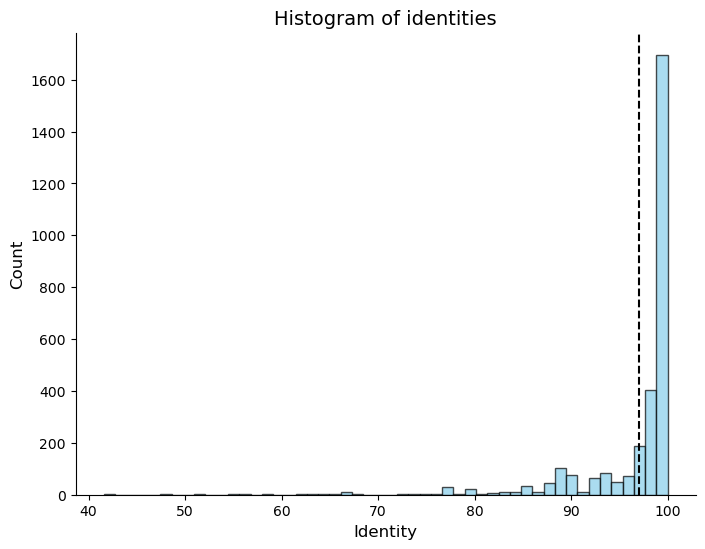

In [38]:
#bin list of identities by values 50 to 55, 55 to 60, 60 to 65, 65 to 70, 70 to 75, 75 to 80, 80 to 85, 85 to 90, 90 to 95, 95 to 100

plt.figure(figsize=(8, 6))

plt.hist(list_of_all_identities, bins = 50, color = 'skyblue', edgecolor='black', alpha = 0.7)
# plt.yscale('log')
plt.xlabel('Identity', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Histogram of identities', fontsize = 14)

#remove frame and white space around plot
sns.despine()
# Add a black dashed vertical line at x = 97
plt.axvline(x=97, color='black', linestyle='--')

plt.savefig(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/identity_histogram.")
# plt.yscale('log')
# plt.savefig(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/identity_histogram_log.png")

In [39]:
# Extract only the ampliconic gene families 
# Defined as sequence identity for at least two copies have ≥97% sequence identity within at least one species.

# Load the TSV file
df = pd.read_csv(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/clusters_identities.tsv", sep='\t')

# Function to check if at least 2 copies have >= 97% identity
def is_ampliconic(sequence_identities):
    # Split the string by semicolons and convert to floats
    identities = [float(identity) for identity in sequence_identities.split(';') if identity]
    
    # Check if there are at least 2 identities >= 97%
    return sum([identity >= 97.0 for identity in identities]) >= 1

# Filter the rows based on the condition for each species (PanTro, HomSap)
filtered_rows = []

for idx, row in df.iterrows():
    # Check for each species column ('PanTro' and 'HomSap') 
    if is_ampliconic(row['PanTro']) or is_ampliconic(row['HomSap']) or is_ampliconic(row['PanPan']) or is_ampliconic(row['GorGor']) or is_ampliconic(row['PonPyg']) or is_ampliconic(row['PonAbe']) or is_ampliconic(row['SymSyn']) :
        filtered_rows.append(row)

# Create a new dataframe with only the ampliconic families
ampliconic_df = pd.DataFrame(filtered_rows)
ampliconic_df

# Save the filtered dataframe to a new TSV file
ampliconic_df.to_csv(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/ampliconic_families.tsv", sep='\t', index=False)

In [40]:
# append the gene family to the genes of the gene_details.tsv file 

# Load the gene_details and clusters files
gene_details_file = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/gene_details.tsv"
clusters_file = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/ampliconic_families.tsv"

gene_details_df = pd.read_csv(gene_details_file, sep='\t')
clusters_df = pd.read_csv(clusters_file, sep='\t')

# Initialize the new column in gene_details_df
gene_details_df["gene_family_symbol"] = ""

# Iterate through each row in gene_details_df
for index, row in gene_details_df.iterrows():
    gene_name = row["Gene"]
    
    # Search for the gene_name in the "Description(s)" column of clusters_df
    matching_row = clusters_df[clusters_df["Description(s)"].str.contains(gene_name, na=False, regex=False)]
    
    if not matching_row.empty:
        # Get the gene_symbol from the matching row
        gene_symbol = matching_row.iloc[0]["gene_symbol"]
        # Append the gene_symbol to the "gene_family_symbol" column in gene_details_df
        gene_details_df.at[index, "gene_family_symbol"] = gene_symbol

# Save the updated DataFrame back to a new file
gene_details_df.to_csv(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/gene_details_updated.tsv", sep='\t', index=False)

print("Updated gene_details.tsv with gene_family_symbol column.")

Updated gene_details.tsv with gene_family_symbol column.


In [41]:
# Apply whether a gene lays within a palindrome
gene_details_df = pd.read_csv(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/gene_details_updated.tsv", sep='\t')

## Check if a gene is within any palindrome
def check_palindrome(specie, gene_start, gene_end):
    # Get the list of palindromes for the given species
    if specie in palindrome_lines_per_species:
        palindromes = palindrome_lines_per_species[specie]
        
        for palindrome in palindromes:
            _, pal_start, pal_end, _, pal_name = palindrome
            
            # Convert coordinates to integers
            pal_start = int(pal_start)
            pal_end = int(pal_end)
            
            # Check if gene coordinates fall within the palindrome range
            if gene_start >= pal_start and gene_end <= pal_end:
                return 'yes', pal_name
    
    return 'no', None
    
# New columns to be added
gene_details_df['in_palindrome'] = 'no'
gene_details_df['palindrome_name'] = None

# Iterate over each row in the dataframe
for idx, row in gene_details_df.iterrows():
    species = row['Species'] 
    gene_start = row['Start'] 
    gene_end = row['End']  
    
    in_palindrome, palindrome_name = check_palindrome(species, gene_start, gene_end)
    
    # Update the dataframe with the results
    gene_details_df.at[idx, 'in_palindrome'] = in_palindrome
    gene_details_df.at[idx, 'palindrome_name'] = palindrome_name

# Save the updated dataframe to a new TSV file
gene_details_df.to_csv(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes.tsv", sep='\t', index=False)

gene_details_df

,Species,Gene,Gene_symbol,Start,End,Strand,Class,gene_family_symbol,in_palindrome,palindrome_name
0,PanTro,ankyrin repeat domain-containing protein SOWAH...,LOC129138932,44260,45063,-,SATELLITE,NaN,no,None
1,PanTro,putative SLC9B1-like protein SLC9B1P1,LOC100615389,4788797,4789013,-,AMPLICONIC,NaN,yes,Q1A
2,PanTro,testis-specific chromodomain protein Y 1,LOC745547,5359052,5360678,+,AMPLICONIC,CDY1,yes,Q1B
3,PanTro,"glutamate dehydrogenase 1, mitochondrial-like",LOC750007,5539041,5540142,+,AMPLICONIC,"glutamate dehydrogenase 1, mitochondrial-like",no,None
4,PanTro,testis-specific Y-encoded protein 3-like,LOC129135297,6661398,6661752,+,ANCESTRAL,TSPY8,no,None
...,...,...,...,...,...,...,...,...,...,...
756,MacFas,testis-specific Y-encoded protein 2-like,LOC141409530,11981323,11981346,-,Unknown,TSPY8,no,None
757,MacFas,testis-specific Y-encoded protein 2-like,LOC141409557,12091183,12091216,+,Unknown,TSPY8,no,None
758,MacFas,deleted in azoospermia protein 1-like,LOC141409531,12794893,12794896,+,Unknown,DAZ1,no,None
759,MacFas,testis-specific chromodomain protein Y 2-like,LOC141409533,13091521,13091606,-,Unknown,CDY1,no,None


In [43]:
# UPDATE THE GENE COORDINATES!

gene_details_file = f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes.tsv"
df = pd.read_csv(gene_details_file, sep="\t")
df

species_to_gff = {
    d['species']: d['data']['path_to_annotation_NCBI'].replace(".gff", "_chrY.gff")
    for d in data
}

def parse_gene_coords(gff_path):
    coords = {}
    with open(gff_path) as g:
        for line in g:
            if line.startswith('#'): continue
            chrom,src,feat,start,end,_,_,_,attr = line.split('\t',8)
            if feat != 'gene': continue
            # pull out gene_symbol (or fallback to gene=)
            md = dict(item.split('=',1) for item in attr.split(';') if '=' in item)
            sym = md.get('gene_symbol') or md.get('gene')
            if sym:
                coords[sym] = (int(start), int(end))
    return coords

gff_cache = {
    sp: parse_gene_coords(path)
    for sp, path in species_to_gff.items()
}

new_starts, new_ends = [], []
for _, row in df.iterrows():
    sp, sym = row['Species'], row['Gene_symbol']
    start,end = gff_cache[sp].get(sym, (row['Start'], row['End']))
    new_starts.append(start)
    new_ends.append(end)

df['Start'] = new_starts
df['End']   = new_ends
df

# save the table 
df.to_csv(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes_coordinates.tsv", sep="\t", index=False)

In [46]:
# remove all rows that have NaN in gene_family_symbol -> all the ones that are not part of a ampliconic gene family
df = df.dropna(subset=["gene_family_symbol"])
df.to_csv(f"{work_dir.replace('x_multicopy','y_multicopy')}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes_coordinates.tsv", sep="\t", index=False)
df

,Species,Gene,Gene_symbol,Start,End,Strand,Class,gene_family_symbol,in_palindrome,palindrome_name
2,PanTro,testis-specific chromodomain protein Y 1,LOC745547,5358723,5360941,+,AMPLICONIC,CDY1,yes,Q1B
3,PanTro,"glutamate dehydrogenase 1, mitochondrial-like",LOC750007,5539042,5540684,+,AMPLICONIC,"glutamate dehydrogenase 1, mitochondrial-like",no,NaN
4,PanTro,testis-specific Y-encoded protein 3-like,LOC129135297,6661276,6664016,+,ANCESTRAL,TSPY8,no,NaN
5,PanTro,testis-specific Y-encoded protein 3,LOC107973386,6672036,6674778,+,ANCESTRAL,TSPY8,no,NaN
6,PanTro,testis-specific Y-encoded protein 3,LOC112207446,6682798,6685540,+,ANCESTRAL,TSPY8,no,NaN
...,...,...,...,...,...,...,...,...,...,...
756,MacFas,testis-specific Y-encoded protein 2-like,LOC141409530,11981124,11983881,-,Unknown,TSPY8,no,NaN
757,MacFas,testis-specific Y-encoded protein 2-like,LOC141409557,12091184,12093921,+,Unknown,TSPY8,no,NaN
758,MacFas,deleted in azoospermia protein 1-like,LOC141409531,12794702,12850544,+,Unknown,DAZ1,no,NaN
759,MacFas,testis-specific chromodomain protein Y 2-like,LOC141409533,13091147,13093961,-,Unknown,CDY1,no,NaN


## Extract the sequences from the reference genome (done for all in a separate script)


In [40]:
## For the X chromosome
## make a gene coordinate .txt file for each species in the species list (defined all the way at the start)

# Read the X chromosome file in again
gene_details_df = pd.read_csv(f"{work_dir}/protein_extracted_longest/clusters_merged/gene_details_updated_with_palindromes.tsv", sep='\t')

# Drop the genes (rows) that are not part of ampliconic gene families -> so have an NaN in the gene_family_symbol column 
gene_details_df = gene_details_df.dropna(subset=['gene_family_symbol'])

# Dictionary mapping species to their specific chromosome names. 
chrom_map = {
    'PanTro': 'NC_072421.2',
    'HomSap': 'NC_060947.1'
}

# Function to create genes.txt for each species
for species in species_list:
    # Filter for the specific species
    species_df = gene_details_df[gene_details_df['Species'] == species]
    
    # Use the predefined work_dir and creeate the gene file
    output_path = f"{work_dir}/{species}_genes.txt"

    with open(output_path, 'w') as f:
        for _, row in species_df.iterrows():
            f.write(f"{row['Gene_symbol']} {chrom_map[species]} {row['Start']} {row['End']}\n")

print("Genes.txt files created for each species.")

Genes.txt files created for each species.


In [41]:
gene_details_df

,Species,Gene,Gene_symbol,Start,End,Class,gene_family_symbol,in_palindrome,palindrome_name
23,PanTro,sperm protein associated with the nucleus on t...,LOC129388397,3487081,3487153,AMPLICONIC,SPANXN4,no,NaN
24,PanTro,SPANX A/D member 3,LOC493983,3566189,3566261,AMPLICONIC,SPANXN4,no,NaN
31,PanTro,variable charge X-linked-like,LOC112207788,6977471,6977870,ANCESTRAL,VCX3B,no,NaN
32,PanTro,variable charge X-linked-like,LOC112206844,6995129,6995528,ANCESTRAL,VCX3B,no,NaN
37,PanTro,variable charge X-linked-like,LOC112206942,8297582,8297684,ANCESTRAL,VCX3B,no,NaN
...,...,...,...,...,...,...,...,...,...
1824,HomSap,cancer/testis antigen 1A,CTAG1A,152821637,152821906,AMPLICONIC,CTAG1A,yes,Q28A
1825,HomSap,cancer/testis antigen 1B,CTAG1B,152854183,152854322,AMPLICONIC,CTAG1A,yes,Q28B
1826,HomSap,cancer/testis antigen 2,CTAG2,152888708,152889072,ANCESTRAL,CTAG1A,no,NaN
1827,HomSap,coagulation factor VIII associated 2,F8A2,153620121,153621237,AMPLICONIC,F8A2,yes,Q29A


In [42]:
# Based on the genes file per species. Now make a FASTA file where the specific sequences of the genes are extracted based on the coordinates of the genes. 
from pyfaidx import Fasta

def extract_gene_sequences(data):
    for species_info in data:
        species = species_info['species']
        genome_file = species_info['data']['ref']
        genes_file = f"{work_dir}/{species}_genes.txt"
        output_file = f"{work_dir}/{species}_gene_sequences.fasta"
        
        # Load genome
        genome = Fasta(genome_file)
        
        # Open output file for writing
        with open(output_file, 'w') as out_f:
            # Read genes file
            with open(genes_file, 'r') as gene_f:
                for line in gene_f:
                    gene, chrom, start, end = line.strip().split()
                    start, end = int(start), int(end)
                    
                    # Extract sequence
                    sequence = genome[chrom][start-1:end]
                    
                    # Write to output file
                    out_f.write(f">{gene}\n{sequence}\n")
        
        print(f"Extracted sequences for {species}")

# Call the function with your data list
extract_gene_sequences(data)

Extracted sequences for PanTro
Extracted sequences for HomSap


In [5]:
# Subset the X and Y one from reference chromosome
# X chromsome PanTro
cmd = f"samtools faidx {data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/GCF_028858775.2_NHGRI_mPanTro3-v2.0_pri_genomic.fna NC_072421.2 > {data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/PanTro_X.fasta"
subprocess.run(cmd, shell=True, check=True)

CompletedProcess(args='samtools faidx /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/PanTro/ncbi_dataset/data/GCF_028858775.2/GCF_028858775.2_NHGRI_mPanTro3-v2.0_pri_genomic.fna NC_072421.2 > /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/PanTro/ncbi_dataset/data/GCF_028858775.2/PanTro_X.fasta', returncode=0)

In [6]:
# index the new fasta files
cmd = f"samtools faidx {data_dir}/references/PanTro/ncbi_dataset/data/GCF_028858775.2/PanTro_X.fasta"
subprocess.run(cmd, shell=True, check=True)

CompletedProcess(args='samtools faidx /home/emma/Amplicons/Workspaces/emma/downloaded_data/references/PanTro/ncbi_dataset/data/GCF_028858775.2/PanTro_X.fasta', returncode=0)

In [12]:
# Iterate over each species in the data list
for species_entry in data:
    species = species_entry['species']  # Get species identifier
    genome_data = species_entry['data']  # Access genome data dictionary
    
    ref_genome = genome_data['ref']  # Reference genome path
    chr_x = genome_data['chr_x']  # X chromosome identifier
    chr_y = genome_data.get('chr_y')  # Y chromosome identifier
    
    # Define output file paths
    x_fasta = f"{os.path.dirname(ref_genome)}/{species}_X.fasta"
    y_fasta = f"{os.path.dirname(ref_genome)}/{species}_Y.fasta"

    # Extract X chromosome
    cmd_x = f"samtools faidx {ref_genome} {chr_x} > {x_fasta}"
    subprocess.run(cmd_x, shell=True, check=True)
    
    # Index the X chromosome FASTA file
    subprocess.run(f"samtools faidx {x_fasta}", shell=True, check=True)

    # Extract Y chromosome
    cmd_y = f"samtools faidx {ref_genome} {chr_y} > {y_fasta}"
    subprocess.run(cmd_y, shell=True, check=True)

    # Index the Y chromosome FASTA file
    subprocess.run(f"samtools faidx {y_fasta}", shell=True, check=True)

    print(f"✅ Processed {species}: X and Y chromosome FASTA files created!")


✅ Processed PanTro: X and Y chromosome FASTA files created!
✅ Processed HomSap: X and Y chromosome FASTA files created!


In [23]:
## BLAST human VCY against macaque Y chromosome

In [24]:
from Bio.Blast.Applications import NcbiblastnCommandline, NcbitblastnCommandline
import pandas as pd

# Paths
human_protein = f"{data_dir}/human_vcy.faa"  # Your human protein sequence
macfas_y = f"{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/MacFas_Y.fasta"
output = f"{data_dir}/blast_results_macfas_vcy.txt"

# Run tBLASTn (protein query vs nucleotide database)
tblastn_cline = NcbitblastnCommandline(
    query=human_protein,
    subject=macfas_y,
    out=output,
    outfmt="6 qseqid sseqid pident length qstart qend sstart send evalue bitscore",
    evalue=1e-5
)

stdout, stderr = tblastn_cline()

# Read and display results
df = pd.read_csv(output, sep='\t', names=[
    'query', 'subject', 'pident', 'length', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'
])

print(df)

/home/emma/miniforge3/envs/amplicon_env/lib/python3.10/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Empty DataFrame
Columns: [query, subject, pident, length, qstart, qend, sstart, send, evalue, bitscore]
Index: []


In [29]:
import subprocess
import pandas as pd

# Paths
human_protein = f"{data_dir}/human_vcy.faa"  # Your human protein sequence
macfas_y = f"{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/MacFas_Y.fasta"
output = f"{data_dir}/blast_results_macfas_vcy.txt"

# Run tBLASTn
cmd = [
    "tblastn",
    "-query", human_protein,
    "-subject", macfas_y,
    "-out", output,
    "-outfmt", "6 qseqid sseqid pident length qstart qend sstart send evalue bitscore",
    "-evalue", "10"  # More permissive
]

subprocess.run(cmd)

# Read results
try:
    df = pd.read_csv(output, sep='\t', names=[
        'query', 'subject', 'pident', 'length', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'
    ])
    
    if df.empty:
        print("No hits found. Try:")
        print("1. Check your protein sequence file exists")
        print("2. Make evalue less stringent (try 1e-1 or 10)")
        print("3. The gene might be too divergent or absent")
    else:
        print(df)
except pd.errors.EmptyDataError:
    print("No hits found")

No hits found. Try:
1. Check your protein sequence file exists
2. Make evalue less stringent (try 1e-1 or 10)
3. The gene might be too divergent or absent


In [41]:
# Check if VCY is already annotated in macaque
#macfas_prot = f"{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/protein.faa"
human_prot = f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/protein.faa",
import subprocess

# Search for "testis-specific basic protein Y"
result = subprocess.run(
    f"grep '^>' {human_prot} | grep -i 'testis-specific basic protein Y'", 
    shell=True, 
    capture_output=True, 
    text=True
)

print(result.stdout)

In [47]:
from Bio import SeqIO

# Human Y chromosome coordinates for VCY
human_ref = f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"
chr_y = "NC_060948.1"  # Human Y chromosome

# Extract region (example coordinates - update with yours)
start = 14892489  # Your VCY start
end = 14892764    # Your VCY end

# Extract sequence
for record in SeqIO.parse(human_ref, "fasta"):
    if chr_y in record.id:
        vcy_seq = record.seq[start-1:end]  # -1 for 0-based indexing
        with open("human_VCY_cds.fna", "w") as out:
            out.write(f">Human_VCY\n{vcy_seq}\n")
        print(f"Extracted {len(vcy_seq)} bp")
        break

Extracted 276 bp


In [48]:
import subprocess

cmd = [
    "blastn",  # nucleotide vs nucleotide
    "-query", "human_VCY_cds.fna",
    "-subject", f"{data_dir}/references/MacFas/ncbi_dataset/data/GCF_037993035.2/MacFas_Y.fasta",
    "-out", "vcy_blast.txt",
    "-outfmt", "6",
    "-evalue", "1e-3"
]

subprocess.run(cmd)

CompletedProcess(args=['blastn', '-query', 'human_VCY_cds.fna', '-subject', '/home/emma/Amplicons/Workspaces/emma/downloaded_data/references/MacFas/ncbi_dataset/data/GCF_037993035.2/MacFas_Y.fasta', '-out', 'vcy_blast.txt', '-outfmt', '6', '-evalue', '1e-3'], returncode=0)

In [51]:
from Bio import SeqIO

# Paths
human_ref = f"{data_dir}/references/HomSap/ncbi_dataset/data/GCF_009914755.1/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"

# Human Y chromosome
chr_y = "NC_060948.1"  # Human Y chromosome

# Your VCY exon 1 coordinates
start = 14962884  # Replace with your actual start
end = 14963615    # Replace with your actual end

# Extract sequence
for record in SeqIO.parse(human_ref, "fasta"):
    if chr_y in record.id:
        exon_seq = record.seq[start-1:end]  # -1 because Python is 0-based
        
        # Save to file
        with open("human_VCY1B_gene.fasta", "w") as out:
            out.write(f">Human_VCY_exon1_{start}_{end}\n{exon_seq}\n")
        
        print(f"Extracted {len(exon_seq)} bp from {chr_y}:{start}-{end}")
        print(f"Saved to: human_VCY_exon1.fna")
        break

Extracted 732 bp from NC_060948.1:14962884-14963615
Saved to: human_VCY_exon1.fna
